In [1]:
import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import time

In [7]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  19294      0 --:--:-- --:--:-- --:--:-- 19294
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objects/114.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.5 MiB/  2.5 MiB]                                    

In [2]:
import torch_xla
import torch_xla.core.xla_model as xm
device = xm.xla_device()
print(device)

xla:1


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle

In [15]:
!kaggle datasets download -d huyngoc99168/wight30

 99% 101M/102M [00:01<00:00, 65.2MB/s] 
100% 102M/102M [00:01<00:00, 57.1MB/s]


In [16]:
!unzip "/content/wight30.zip"

Archive:  /content/wight30.zip
  inflating: weight_30.pth           


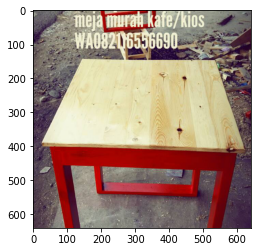

In [94]:
from matplotlib.pyplot import imshow
from PIL import Image
Test_df = pd.read_csv("/content/shopee/test.csv")
file_name = Test_df["filename"]
Img = Image.open("/content/shopee/test/test/" + file_name[0])
imshow(Img)

In [37]:
from _Inferences import InferenceLoader
def default_loader(path):
        from torchvision import get_image_backend
        if get_image_backend() == 'accimage':
            return accimage_loader(path)
        else:
            return pil_loader(path)
def pil_loader(path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
Ds_valid = InferenceLoader("/content/shopee/test/", default_loader, extensions=".jpg", transform = transform)
Dl_valid = DataLoader(Ds_valid, batch_size = 1)

In [10]:
resnet50 = models.resnet50(pretrained = True)
num_feature = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_feature, 42)

In [ ]:
summary(resnet50, (3,224,224))

In [18]:
resnet50.load_state_dict(torch.load("/content/weight_30.pth"))

<All keys matched successfully>

In [ ]:
resnet50.to(device)

In [44]:
!pip install barbar

In [103]:
import os
from barbar import Bar
resnet50.eval()
count = 0
with torch.no_grad():
  for idx, (X,y) in enumerate(Dl_valid):
    count += 1
    print("Instance: {}/{}".format(idx, len(Dl_valid)))
    X = X.to(device)
    y_pred = resnet50(X)
    y = y[0]
    _, predicted = torch.max(y_pred, 1)
    name = y.split(os.path.sep)[-1]
    Test_df.loc[Test_df.filename == name, "category"] = str(predicted.item())

Streaming output truncated to the last 5000 lines.
Instance: 7193/12192
Instance: 7194/12192
Instance: 7195/12192
Instance: 7196/12192
Instance: 7197/12192
Instance: 7198/12192
Instance: 7199/12192
Instance: 7200/12192
Instance: 7201/12192
Instance: 7202/12192
Instance: 7203/12192
Instance: 7204/12192
Instance: 7205/12192
Instance: 7206/12192
Instance: 7207/12192
Instance: 7208/12192
Instance: 7209/12192
Instance: 7210/12192
Instance: 7211/12192
Instance: 7212/12192
Instance: 7213/12192
Instance: 7214/12192
Instance: 7215/12192
Instance: 7216/12192
Instance: 7217/12192
Instance: 7218/12192
Instance: 7219/12192
Instance: 7220/12192
Instance: 7221/12192
Instance: 7222/12192
Instance: 7223/12192
Instance: 7224/12192
Instance: 7225/12192
Instance: 7226/12192
Instance: 7227/12192
Instance: 7228/12192
Instance: 7229/12192
Instance: 7230/12192
Instance: 7231/12192
Instance: 7232/12192
Instance: 7233/12192
Instance: 7234/12192
Instance: 7235/12192
Instance: 7236/12192
Instance: 7237/12192
Inst

In [104]:
Test_df

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,7
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,4
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12
...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,16
12182,efbe41a1c2b666b70e337e438559808b.jpg,19
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,13
12184,ac3d136124617637a05ba66694e381ef.jpg,15


In [111]:
pd.DataFrame.to_csv(Test_df, "/content/Submission1.csv", index = False)

In [110]:
print(Test_df.columns)

Index(['filename', 'category'], dtype='object')
